In [1]:
import numpy as np

## Calculo matrices Y0,X para loglikehood
def calc_Y0X(data): #data must have mean 0
    #Y0 is computed
    Y0 = data[:,p:] #pre-sample removed for Y0
    
    #X is computed
    X = []
    for i in range(p-1,-1,-1):
        X.append(data[:,i:(N-p+i)]) 
    X = np.concatenate(X,axis=0)
    
    return {"Y0":Y0,"X":X}

## Calculo loglikehood (matricial)
def loglhood(CovU,Y0,A,X):
    #Loglikehood accoring to Lutkepohl 2005
    #Constant term KT/2 ln2pi neglected
    #T = Y0.shape[1]
    
    trace_mat = np.transpose(Y0 - A@X) @ np.linalg.inv(CovU) @ (Y0 - A@X)
    out = -(Y0.shape[1]/2)*np.log(np.linalg.det(CovU)) -1/2*np.trace(trace_mat) 
    return out 

## Calculo loglikehood (element-wise)
def val_loglhood(theta,Y0,X,flag_print):
    #theta: vector con coeficientes para A, CovU
    #flag_print: si se desea imprimir A, CovU para su revision
    #A     = [a_1,...,a_Kp], donde a_j corresponde a la columna j de A (j=1,...,Kp)
    #CovU  = [u_1,...,u_K],  donde u_j corresponde a la columna j de CovU (j=1,...,K)
    #theta = [vec(A);vec(CovU)] (; indica abajo, no a la derecha, i.e. formato MATLAB)
    #theta = [a_1;...;a_Kp;u_1;...;u_K]
    
    #dimensiones se pueden rescatar de Y0,X
    Kv = Y0.shape[0] #K
    Tv = Y0.shape[1] #T
    pv = int(X.shape[0]/Kv) #p (orden VAR)
    
    #se verifica que theta tenga las dimensiones correctas
    if(not(theta.shape[0] == (pv*Kv**2 + Kv**2))):
        print("ERROR: dimensiones theta no coinciden con Y0,X")
        
    #se re-construyen matrices A, CovU a partir de vector theta entregado
    A    = np.reshape(theta[:pv*Kv**2],(Kv*pv,Kv)).swapaxes(0,1)
    CovU = np.reshape(theta[pv*Kv**2:],(Kv,Kv)).swapaxes(0,1)
    
    #se chequea que la matriz CovU sea adecuada (semidefinida positiva)
    eig_val_U = np.linalg.eigvals(CovU)
    flag_sdp  = np.all(eig_val_U >= 0) #valores propios no negativos
    
    #se chequea que la matriz A sea adecuada (proceso estable, pag 15 Lutkepohl)
    if(pv==1): #no es necesario agregar bloque 
        A_test = A
    else:
        A_block  = np.block(np.eye(Kv*(pv-1)))
        A_zeros  = np.zeros((Kv*(pv-1),Kv))
        A_bottom = np.concatenate((A_block,A_zeros),axis=1)
        A_test   = np.concatenate((A,A_bottom),axis=0)
    eig_val_A   = np.absolute(np.linalg.eigvals(A_test))
    flag_stable = np.all(eig_val_A < 1) #valores propios absolutos menores a 1
    
    #se evalua la funcion de loglikelihood
    if(not(flag_sdp)):
        val = -np.inf #fuera del soporte
        if(flag_print): #detalles del error
            print("Matriz CovU no es semidefinita positiva")
            print(CovU)
            print(eig_val_U)
    elif(not(flag_stable)):
        val = -np.inf
        if(flag_print): 
            print("Matriz A no es estable")
            print(A)
            print(eig_val_A)
    else: #Parametros matrices A,CovU validos
        val = loglhood(CovU,Y0,A,X) 
        if(flag_print): #se muestran matrices A, CovU construidas
            print("Matriz A resulante:")
            print(A)
            print("-----")
            print("Matriz CovU resulante:")
            print(CovU)
        
    return val

In [9]:
## Parametros modelo VAR(p)
N = 10  #total ammount to data (including pre-sample)
K = 2   #dimension variables aleatorias
p = 1   #orden VAR
T = N-p #size of data after removing pre-sample 

## (Temporal) inicializacion de datos ficticios
data    = np.random.rand(K,N) #unnormalized data (includes pre-sample)
mu_mean = np.transpose(np.asmatrix(np.mean(data,axis=1))) #data mean
data    = data - mu_mean #data is normalized 
Y0X     = calc_Y0X(data)

### Metodo 1 de prueba: matrices A, CovU generadas previamente
## matriz A (K x Kp)
#A = np.random.rand(K,K*p)
## matriz de Covarianza para ruido U (K x K)
#CovU = np.random.rand(K,K)
#CovU = CovU @ np.transpose(CovU) #generate semidefinite matrix
#flag_sdp = np.all(np.linalg.eigvals(CovU) >= 0) #checkeo valores propios postivos (matrix semidefinida)
#if (not(flag_sdp)):
#    print("ERROR: Matriz no es semidefinida positiva")
#out1 = loglhood(CovU,Y0X['Y0'],A,Y0X['X'])
#print(out1)


## Metodo 2 de prueba: se entrega vector theta con coeficientes matrices A,CovU
thetaA = np.random.rand(p*K**2,1) #coeficientes matriz A
thetaU = np.random.rand(K**2,1) #coeficientes matriz CovU
theta  = np.concatenate((thetaA,thetaU),axis=0)
out2   = val_loglhood(theta,Y0X['Y0'],Y0X['X'],True)
print(out2)

Matriz A resulante:
[[0.0415647  0.49501473]
 [0.4536736  0.26284492]]
-----
Matriz CovU resulante:
[[0.27615103 0.40532735]
 [0.26315833 0.92528575]]
7.076245408202329


## Case study

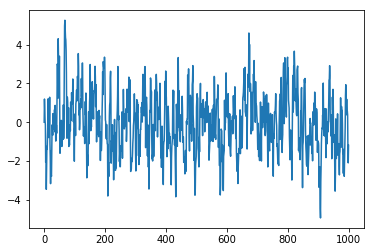

-0.005370707885318843


In [11]:
from scipy.stats import norm
import matplotlib.pyplot as plt

#Parametros AR(1)
x0 = 0 #punto inicio
std_dv = 1
N_samples = 1000
phi = 0.7 #coef AR(1)

#Simula serie de tiempo
noise = norm.rvs(loc=0,scale=std_dv,size=N_samples)
xt = [0]*N_samples
xt[0] = x0
for t in range(1,N_samples):
    xt[t] = phi*xt[t-1] + noise[t-1]
    
#Grafico serie
plt.plot(xt)
plt.show()
print(np.mean(xt))

In [12]:
N = N_samples  #total ammount to data (including pre-sample)
K = 1   #dimension variables aleatorias
p = 1   #orden VAR
T = N-p #size of data after removing pre-sample 

x_mat = np.matrix(xt) #data to matrix format
Y0X = calc_Y0X(x_mat)

(90, 15)


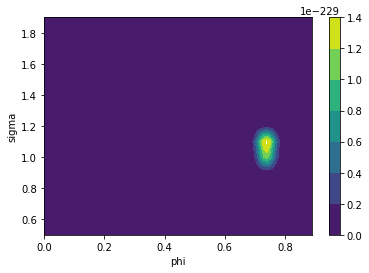

In [13]:
phi,sigma = np.mgrid[0:0.9:.01,0.5:2:0.1]
print(phi.shape)
lhood_mat = np.zeros(phi.shape)

for i in range(0,phi.shape[0]):
    for j in range(0,phi.shape[1]):
        A    = np.matrix(phi[i,j])
        CovU = np.matrix(sigma[i,j])
        lhood_mat[i,j] = np.exp(loglhood(CovU,Y0X['Y0'],A,Y0X['X']))

fig, ax = plt.subplots(1, 1)
cf = ax.contourf(phi, sigma, lhood_mat)
fig.colorbar(cf)
ax.set_xlabel('phi')
ax.set_ylabel('sigma')
#ax.set_xlim([0.6,0.8])
#ax.set_ylim([0.8,1.2])
plt.show()